In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(43)
import os
from glob import glob
from pathlib import Path
import xmltodict
import pandas as pd

In [9]:
classes = ['passenger_car', 'pedestrian', 'bus', 'tram', 'utility_vehicle', 'lorry']
class_colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:brown', 'tab:purple']
DATASET_PATH = 'traffic_cams/main_dataset' # change this
TEST_DATASET_PATH = 'traffic_cams/test_resized' # change this
IMG_W, IMG_H = 1280, 720   # All images provided, including test, are of this size.

In [10]:
# Here we open one image and corresponding annotation, and access relevant data

img_paths = glob(f"{DATASET_PATH}/images/*.jpg")
img_path = img_paths[107]
img = Image.open(img_path)
img_path = Path(img_path)
ann_path = f'{DATASET_PATH}/Annotations/{img_path.stem}.xml'
if os.path.isfile(ann_path):  # Read annotation, if file does not exist 
    with open(ann_path) as f:
        ann_data = f.read()

ann_data = xmltodict.parse(ann_data)['annotation']
image_id =  Path(img_path).stem
print(f'Image ID {image_id}, size: {ann_data['size']}')
print(f'Objects in the image: ')

if not isinstance(ann_data['object'], list):  # If not a list, only 1 object, make a list
    ann_data['object'] = [ann_data['object']]
    
for i in range(len(ann_data['object'])):
    obj_data = ann_data['object'][i] 
    print(f'\tclass_name: {obj_data['name']}')
    print(f'\tbbox: {obj_data['bndbox']}')
    print(f'\t------')

Image ID 1a424355-cam046_20250322_111014, size: {'width': '1280', 'height': '720', 'depth': '3'}
Objects in the image: 
	class_name: passenger_car
	bbox: {'xmin': '143', 'ymin': '27', 'xmax': '239', 'ymax': '103'}
	------
	class_name: passenger_car
	bbox: {'xmin': '272', 'ymin': '79', 'xmax': '433', 'ymax': '198'}
	------


In [11]:
def draw_rectangle(ax, top_left_x, top_left_y, width, height, color='red'):
    top_left = (top_left_x, top_left_y)
    bottom_right = (top_left_x + width, top_left_y + height)

    # Plotting each edge of the rectangle on the specified axes
    ax.plot([top_left[0], top_left[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Left edge
    ax.plot([bottom_right[0], bottom_right[0]], [top_left[1], bottom_right[1]], '-', color=color)  # Right edge
    ax.plot([top_left[0], bottom_right[0]], [top_left[1], top_left[1]], '-', color=color)  # Top edge
    ax.plot([top_left[0], bottom_right[0]], [bottom_right[1], bottom_right[1]], '-', color=color)  # Bottom edge

def plot_annotations(ax, ann_data):
    for i in range(len(ann_data['object'])):
        if isinstance(ann_data['object'], list):
            obj_data = ann_data['object'][i]
        else: 
            obj_data = ann_data['object']
        bbox = obj_data['bndbox']
        cls_name = obj_data['name']
        cls_id = classes.index(cls_name)
        color = class_colors[cls_id]
        top_left_x, top_left_y, width, height = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']) - int(bbox['xmin']), int(bbox['ymax']) - int(bbox['ymin'])
        
        draw_rectangle(ax, top_left_x, top_left_y, width, height, color=color)

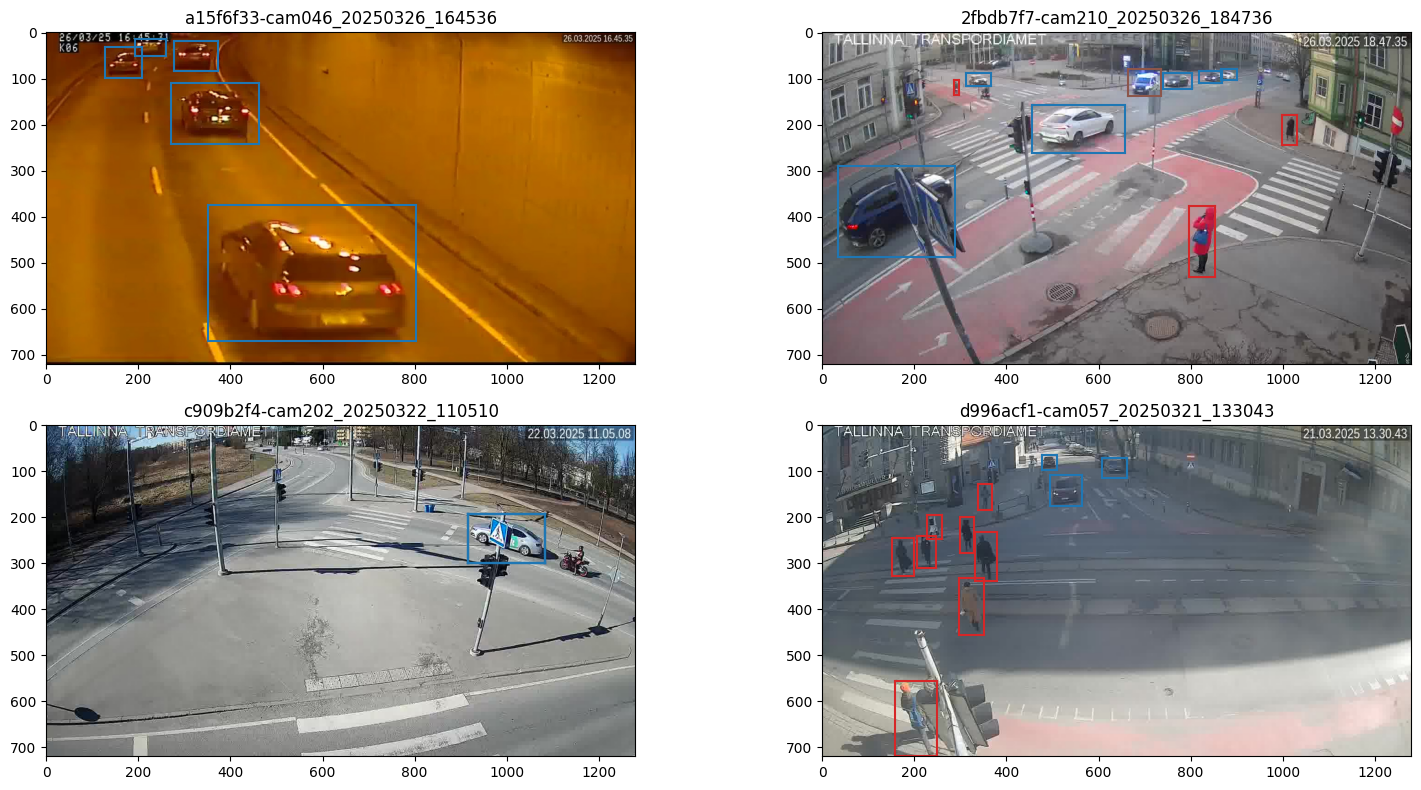

In [12]:
#  Plot random images and respective annotations from the dataset

img_paths = glob(f"{DATASET_PATH}/images/*.jpg")
imgs_to_show = 4
fig, axes = plt.subplots(2, 2, figsize=(16,8))
axes = axes.flatten()
for i in range(imgs_to_show):
    j = random.randint(0, len(img_paths)-1)
    img_path = img_paths[j]
    img = Image.open(img_path)
    img_path = Path(img_path)
    ax = axes[i]
    ax.imshow(img)

    ann_path = f'{DATASET_PATH}/Annotations/{img_path.stem}.xml'
    if os.path.isfile(ann_path):  # Read annotation, if file does not exist - no objects
        with open(ann_path) as f:
            ann_data = f.read()
    else: 
        continue 
    ann_data = xmltodict.parse(ann_data)['annotation']
    plot_annotations(ax, ann_data)
    ax.set_title(Path(img_path.stem))
fig.tight_layout()

In [13]:
"""
Make the submission
Must be a csv file with columns: 
    image_id    - original test image file name, without file extension
    confidence  - value from 0 - 1, how confident the model in the prediction for this specific class
    class_name  - class name, exactly from here ['passenger_car', 'pedestrian', 'bus', 'tram', 'utility_vehicle', 'lorry']
    x_min       - bbox x minimum in pixels relative to the ORIGINAL image size H=720, W=1280
    y_min       - =/=
    x_max       - =/=
    y_max       - =/=
"""
confidence_thr = 0.99
test_img_paths = glob(f"{TEST_DATASET_PATH}/images/*.jpg")

out_data = {'image_id':[], 
            'confidence':[],
            'class_name':[],
            'x_min':[],
            'y_min':[],
            'x_max':[],
            'y_max':[]}
for i in range(len(test_img_paths)):
    path = test_img_paths[i]
    img_id = Path(path).stem
    image = Image.open(path,mode='r') 

    # In practice you would have something like this: 
        # transf_image = transform(image).unsqueeze(0).to(device)
        # pred_targets = model.forward(transf_image).cpu().detach()
        # class_ids, confidences, bboxes = targets_to_results(pred_targets[0], ...)
        # class_ids, confidences, bboxes = nms_xywh(class_ids, confidences, bboxes, score_threshold=0.5, iou_threshold=0.2) 

    n_preds = 5

    class_ids = np.random.randint(0, len(classes)-1, size=n_preds)
    confidences = np.random.random(size=n_preds)
    bboxes_xywh = np.random.random(size=(n_preds, 4))
    bboxes_xywh[:, [0, 2]] *= IMG_W  # x and w
    bboxes_xywh[:, [1, 3]] *= IMG_H   # y and h

    for j in range(len(class_ids)): 
        #print(f'\t{j}')
        class_id = class_ids[j]
        conf = confidences[j]
        x, y, w, h = bboxes_xywh[j]
        class_id = int(class_id)
        out_data['image_id'].append(img_id)
        out_data['confidence'].append(conf)
        out_data['class_name'].append(classes[class_id])
        out_data['x_min'].append(x-w/2)
        out_data['y_min'].append(y-h/2)
        out_data['x_max'].append(x+w/2)
        out_data['y_max'].append(y+h/2)

df = pd.DataFrame(out_data)
df.to_csv('sample_submission.csv', index_label='ID', index=True)

In [14]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
competition = "object-detection-from-traffic-cams"          
submission_file = "submission.csv"  
submission_message = "Random submission test"
api.competition_submit(submission_file, submission_message, competition)

100%|██████████| 59.0/59.0 [00:00<00:00, 157B/s]


{"message": "Successfully submitted to Traffic.jpeg - Tallinn webcam object detection", "ref": 44055289}